In [1]:
%config Completer.use_jedi = False

import sys
sys.path.insert(1,'../contour_integ_models/')
sys.path.insert(1,'../dev/')

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')


# Pytorch related
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data as dt
from torchinfo import summary
import torchvision.models as pretrained_models
from alexnet_pytorch import AlexNet
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo
# from IPython.html.widgets import interact, interactive, fixed


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline



import numpy as np
import pandas as pd
import os
import glob
import json

import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson


# Extra imports
from lib.feature_extractor import FeatureExtractor
from lib.custom_dataset import Contour_Dataset, Psychophysics_Dataset
from lib.build_fe_ft_models import *
from lib.misc_functions import *
from lib.field_stim_functions import *


updated june4


# Hyperparameters

In [2]:
img_dim=512

batch_size=15
num_workers=8
device = torch.device('cuda:'+'3')
# device = 'cpu'

print(device)

cuda:3


### Extract all the values from the config variables

In [3]:
from visualdiet_savedmodel_config import *

print('\n Visual Diet config \n')
visual_diet_config = psychophysics_visual_diet_config
print(visual_diet_config)


print('\n Saved Model config \n')
print(saved_model_config)



 Visual Diet config 

{'root_directory': '/home/jovyan/work/Datasets/contour_integration/model-psychophysics/experiment_1/', 'get_B': [15, 30, 45, 60, 75], 'get_D': [32], 'get_A': [0], 'get_numElements': [12]}

 Saved Model config 

{'saved_model_directory': '/home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/contour_integ_behavior/../contour_integ_models/saved_model/'}


In [4]:
saved_directory = saved_model_config['saved_model_directory']

In [5]:
root_directory=visual_diet_config['root_directory']
get_B=visual_diet_config['get_B']
get_D=visual_diet_config['get_D']
get_A=visual_diet_config['get_A']
get_numElements=visual_diet_config['get_numElements']

### Data Transforms

In [6]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

data_transform_without_norm = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor()                    
 ])

# Human Behavior

In [8]:
def load_variables(filename):
    """
    Load multiple Python variables from a file.
    
    Parameters:
    - filename (str): the name of the file to load from.
    
    Returns:
    - dict: A dictionary containing the loaded variables.
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [9]:
def get_percent_correct(all_participants_filename,all_participants_correct,all_participants_beta):
    unique_images=np.unique(all_participants_filename)

    accuracy_image=[]
    beta_image=[]

    for img in unique_images:
        accuracy_image.append(np.mean(all_participants_correct[np.where(all_participants_filename==img)]))
        beta_image.append(np.mean(all_participants_beta[np.where(all_participants_filename==img)]))
        
    return np.array(accuracy_image),np.array(beta_image),unique_images

In [10]:
data = load_variables('./contour_exp1/analysis_data/analysis_data.pkl')

all_participants_filename=data['all_participants_filename']
all_participants_correct=data['all_participants_correct']
all_participants_beta=data['all_participants_beta']

print(all_participants_beta.shape)

(78, 200)


### Human Contour Signal at level of individual trials

In [11]:
human_img_signal,beta_image,unique_images=get_percent_correct(all_participants_filename,all_participants_correct,all_participants_beta)
unique_beta_vals = np.unique(beta_image)

print(human_img_signal.shape)
print(unique_beta_vals)

(1000,)
[15. 30. 45. 60. 75.]


### Human Beta-wise Accuracy

In [12]:
all_participants_unique_beta={}
human_unique_beta_acc=[]
for b in np.unique(all_participants_beta):
    all_participants_unique_beta[b]={}
    all_participants_unique_beta[b]['mean']=np.mean(all_participants_correct[np.where(all_participants_beta==b)])
    all_participants_unique_beta[b]['std']=np.std(all_participants_correct[np.where(all_participants_beta==b)])
    human_unique_beta_acc.append([np.mean(all_participants_correct[np.where(all_participants_beta==b)]),np.std(all_participants_correct[np.where(all_participants_beta==b)])])
human_unique_beta_acc=np.array(human_unique_beta_acc)

print(all_participants_unique_beta)

print(human_unique_beta_acc)

{15: {'mean': 0.9365384615384615, 'std': 0.24379124594134455}, 30: {'mean': 0.8567307692307692, 'std': 0.35034719676918163}, 45: {'mean': 0.6506410256410257, 'std': 0.47676753391335264}, 60: {'mean': 0.49775641025641026, 'std': 0.4999949662797241}, 75: {'mean': 0.4592948717948718, 'std': 0.49834033806004924}}
[[0.93653846 0.24379125]
 [0.85673077 0.3503472 ]
 [0.65064103 0.47676753]
 [0.49775641 0.49999497]
 [0.45929487 0.49834034]]


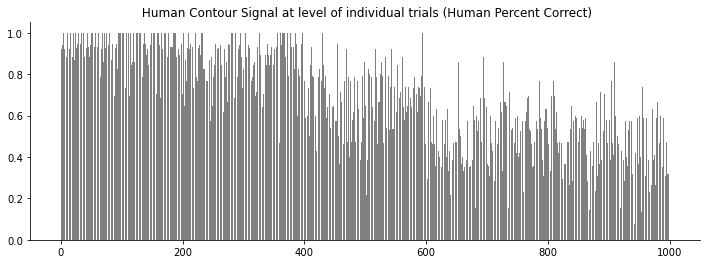

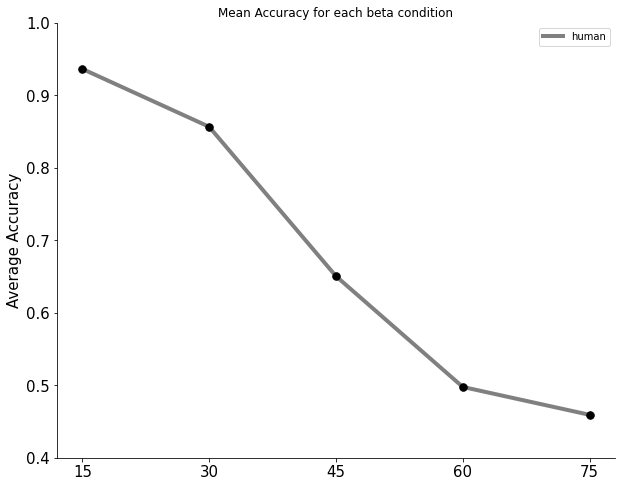

In [13]:
plt.figure(figsize=(12,4))
plt.bar(range(len(human_img_signal)), human_img_signal,color='gray')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title(' Human Contour Signal at level of individual trials (Human Percent Correct)')
plt.show()




plt.figure(figsize=(10,8))
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Average Accuracy',fontsize=15)
plt.ylim(0.4,1.0)
plt.title('Mean Accuracy for each beta condition')
plt.legend()
plt.show()

# Model Behavior

In [14]:
softmax_layer=nn.Softmax(dim=1)

In [15]:
# Imagenet Finetune Broad
sup_regular_finetune_files = glob.glob(os.path.join(saved_directory,'*.pt'))


In [16]:
sup_regular_finetune_files=sorted(sup_regular_finetune_files)

In [17]:
for i,file in enumerate(sup_regular_finetune_files):
    print(i,file)

0 /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/contour_integ_behavior/../contour_integ_models/saved_model/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt
1 /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/contour_integ_behavior/../contour_integ_models/saved_model/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen.pt


### Select the model from the directory

In [18]:
file=sup_regular_finetune_files[0]
print(file)

/home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/contour_integ_behavior/../contour_integ_models/saved_model/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt


In [19]:
checkpoint=torch.load(file)
loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)

_IncompatibleKeys(missing_keys=['base_model.classifier.1.weight', 'base_model.classifier.1.bias', 'base_model.classifier.4.weight', 'base_model.classifier.4.bias', 'base_model.classifier.6.weight', 'base_model.classifier.6.bias'], unexpected_keys=[])

In [20]:
print(checkpoint['visual_diet_config'])
print(checkpoint['metrics']['val_acc'][-1])

{'root_directory': '/home/jovyan/work/Datasets/contour_integration/model-training/config_0/', 'get_B': [0, 15, 30, 45, 60, 75], 'get_D': [32], 'get_A': [0], 'get_numElements': [12]}
0.915


### Computing contour signal in the model over the psychophysical stimuli

In [21]:
contour_present=None
contour_absent=None

### When contour is present

In [22]:
psychophysics_dataset_norm = Psychophysics_Dataset(root=root_directory,transform=data_transform,get_B=get_B,get_D=get_D,get_A=get_A,get_contour='contour')
psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)



In [23]:
all_betas=[]
all_labels=[]
all_outputs=[]
all_preds=[]
all_recorder_path=[]


for (inputs, b, d, a, nel, labels, record) in tqdm(psychophysics_loader_norm):
    inputs=inputs.to(device)
    output=loaded_spliced_model.forward(inputs).detach().cpu()
    _, preds = torch.max(output, 1)
        
    all_preds.append(preds)
    
    all_outputs.append(output)
    all_betas.append(b)
    all_labels.append(labels)
    all_recorder_path.append(np.array(record))

all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_preds=torch.cat(all_preds).numpy()
all_outputs=torch.cat(all_outputs).numpy()
all_recorder_path=np.concatenate(all_recorder_path)

print(all_betas.shape)
print(all_recorder_path.shape)

contour_present=all_outputs

  0%|          | 0/67 [00:00<?, ?it/s]

(1000,)
(1000,)


### When contour is absent

In [24]:
psychophysics_dataset_norm = Psychophysics_Dataset(root=root_directory,transform=data_transform,get_B=get_B,get_D=get_D,get_A=get_A,get_contour='control')
psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [25]:
all_betas=[]
all_labels=[]
all_outputs=[]
all_preds=[]
all_recorder_path=[]


for (inputs, b, d, a, nel, labels, record) in tqdm(psychophysics_loader_norm):
    inputs=inputs.to(device)
    output=loaded_spliced_model.forward(inputs).detach().cpu()
    _, preds = torch.max(output, 1)
        
    all_preds.append(preds)
    
    # all_outputs.append(softmax_layer(output))
    all_outputs.append(output)
    
    all_betas.append(b)
    all_labels.append(labels)
    all_recorder_path.append(np.array(record))

all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_preds=torch.cat(all_preds).numpy()
all_outputs=torch.cat(all_outputs).numpy()
all_recorder_path=np.concatenate(all_recorder_path)

print(all_betas.shape)
print(all_recorder_path.shape)

contour_absent=all_outputs

  0%|          | 0/67 [00:00<?, ?it/s]

(1000,)
(1000,)


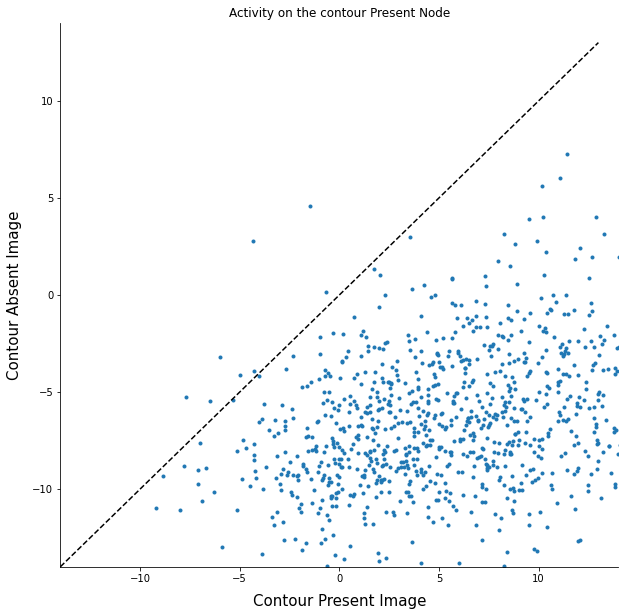

In [26]:
plt.figure(figsize=(10,10))
plt.plot(contour_present[:,1],contour_absent[:,1],'.')
plt.plot(np.arange(-14,14),np.arange(-14,14),linestyle='--',color='k')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Contour Present Image',fontsize=15,labelpad=10)
plt.ylabel('Contour Absent Image',fontsize=15,labelpad=10)

plt.ylim(-14,14)
plt.xlim(-14,14)
plt.title('Activity on the contour Present Node')
plt.show()



In [27]:
## Computing the perpendicular distance for all trials
model_img_signal=((contour_present - contour_absent)/np.sqrt(2))[:,1]

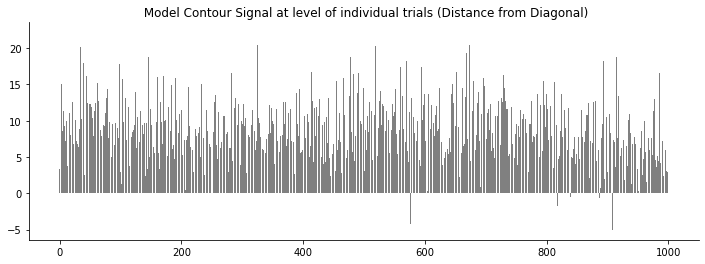

In [28]:
plt.figure(figsize=(12,4))
plt.bar(range(len(model_img_signal)), model_img_signal,color='gray')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title(' Model Contour Signal at level of individual trials (Distance from Diagonal)')
plt.show()


# Model-Human Alignment at the level of individual trials

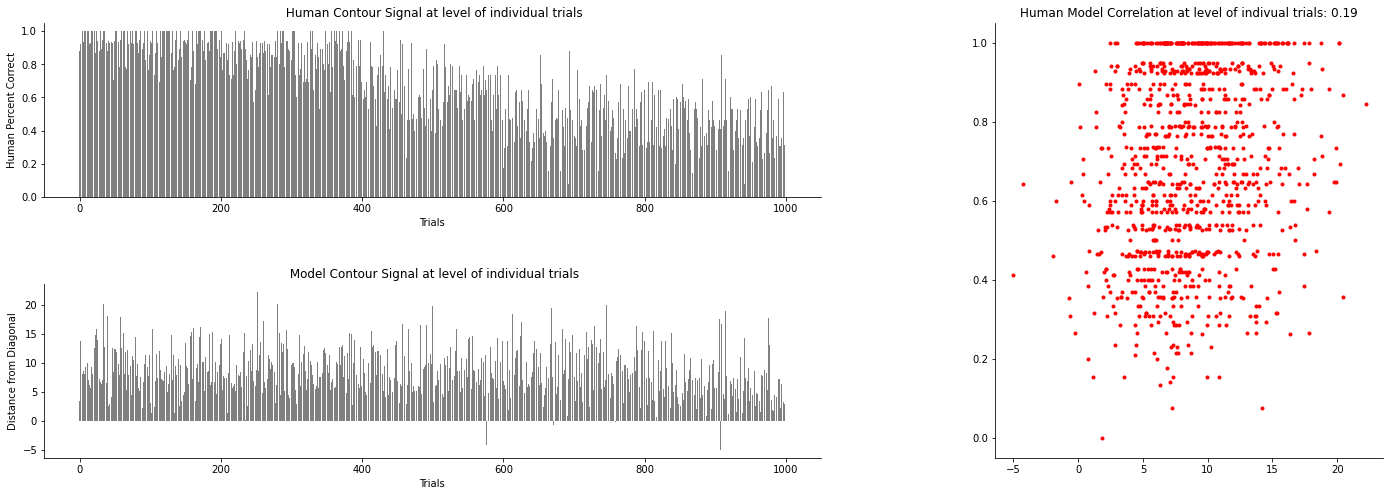

In [40]:
# Create a figure
plt.figure(figsize=(24,8))
# Create a GridSpec object
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])
# Adjust space between the rows
gs.update(wspace=0.3, hspace=0.5)



# First subplot: Top-left
ax1 = plt.subplot(gs[0, 0])

# Second subplot: Bottom-left
ax2 = plt.subplot(gs[1, 0])

# Third subplot: Top-Right and Bottom-Right
ax3 = plt.subplot(gs[:, 1])




# First subplot: Top-left
ax1.bar(range(len(human_img_signal)), human_img_signal,color='gray')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel('Trials')
ax1.set_ylabel('Human Percent Correct')
ax1.set_title(' Human Contour Signal at level of individual trials')





# Second subplot: Bottom-left
ax2.bar(range(len(model_img_signal)), model_img_signal,color='gray')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel('Trials')
ax2.set_ylabel('Distance from Diagonal')
ax2.set_title(' Model Contour Signal at level of individual trials')



# Third subplot: Top-Right and Bottom-Right
ax3.plot(model_img_signal,human_img_signal,'.',color='red')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_title('Human Model Correlation at level of indivual trials: ' + str(round(np.corrcoef(model_img_signal,human_img_signal)[0,1],2)))
plt.show()

In [30]:
## Result Stats
# vectors
vector_a = model_img_signal
vector_b = human_img_signal

# Calculate Pearson's r
pearson_r, pearson_p_value = stats.pearsonr(vector_a, vector_b)

# Calculate Spearman's rho
spearman_rho, spearman_p_value = stats.spearmanr(vector_a, vector_b)

# Calculate MSE and RMSE
mse = mean_squared_error(vector_a, vector_b)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(vector_a, vector_b)

# Perform Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(vector_a, vector_b)

# Calculating R-squared
r_squared = r_value**2


# To calculate the confidence interval for Pearson's correlation coefficient
def pearson_confidence(r, n, alpha=0.05):
    """
    Calculate the confidence interval for Pearson's correlation coefficient.
    
    Args:
    r: The correlation coefficient.
    n: The number of observations.
    alpha: The significance level (default is 0.05 for a 95% confidence interval).
    
    Returns:
    A tuple containing the lower and upper bounds of the confidence interval.
    """
    # Fisher's z transformation
    z = np.arctanh(r)
    # Standard error
    se = 1 / np.sqrt(n - 3)
    # z critical value
    z_crit = stats.norm.ppf(1 - alpha/2)
    # Margin of error
    moe = z_crit * se
    # Calculate the confidence interval using the inverse Fisher transformation
    z_lower = z - moe
    z_upper = z + moe
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    return (r_lower, r_upper)

# Calculate the confidence interval for Pearson's r
pearson_confidence_interval = pearson_confidence(pearson_r, len(vector_a))


# Results
results = {
    'pearson_r': pearson_r,
    'pearson_p_value': pearson_p_value,
    'pearson_confidence_val': pearson_confidence_interval,
    'spearman_rho': spearman_rho,
    'spearman_p_value': spearman_p_value,
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_squared,
    'regression_p_value': p_value
}


print('Printing All Results for the given Model')
results

Printing All Results for the given Model


{'pearson_r': 0.19076372138213046,
 'pearson_p_value': 1.1954037283559782e-09,
 'pearson_confidence_val': (0.13031170922684407, 0.24980263018823431),
 'spearman_rho': 0.19429035745281698,
 'spearman_p_value': 5.812031552076496e-10,
 'mse': 81.33477940277159,
 'rmse': 9.018579677686038,
 'mae': 8.094695085563929,
 'slope': 0.010773424100551739,
 'intercept': 0.5844484490752956,
 'r_squared': 0.03639079739555907,
 'regression_p_value': 1.1954037283560074e-09}

### Trial with strongest signal in model and humans

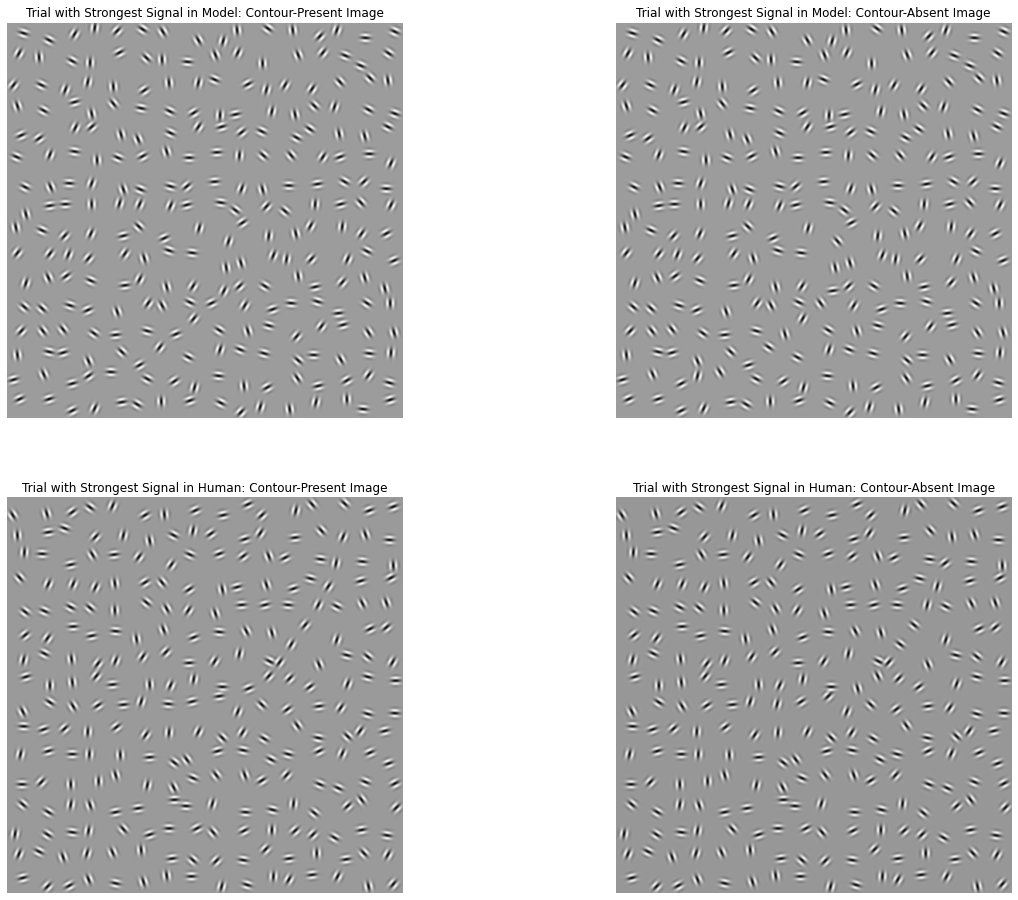

In [31]:
image_recorder_dict=torch.load(all_recorder_path[np.argmax(model_img_signal)])
_, _, model_img_contour_background, model_img_control_background=image_renderer(image_recorder_dict)


image_recorder_dict=torch.load(all_recorder_path[np.argmax(human_img_signal)])
_, _, human_img_contour_background, human_img_control_background=image_renderer(image_recorder_dict)


plt.figure(figsize=(20,16))


plt.subplot(2,2,1)
plt.imshow(np.array(model_img_contour_background),cmap='gray')
plt.axis('off')
plt.title('Trial with Strongest Signal in Model: Contour-Present Image')



plt.subplot(2,2,2)
plt.imshow(np.array(model_img_control_background),cmap='gray')
plt.axis('off')
plt.title('Trial with Strongest Signal in Model: Contour-Absent Image')




plt.subplot(2,2,3)
plt.imshow(np.array(human_img_contour_background),cmap='gray')
plt.axis('off')
plt.title('Trial with Strongest Signal in Human: Contour-Present Image')





plt.subplot(2,2,4)
plt.imshow(np.array(human_img_control_background),cmap='gray')
plt.axis('off')
plt.title('Trial with Strongest Signal in Human: Contour-Absent Image')








plt.show()

### Trial with weakest signal in model and humans

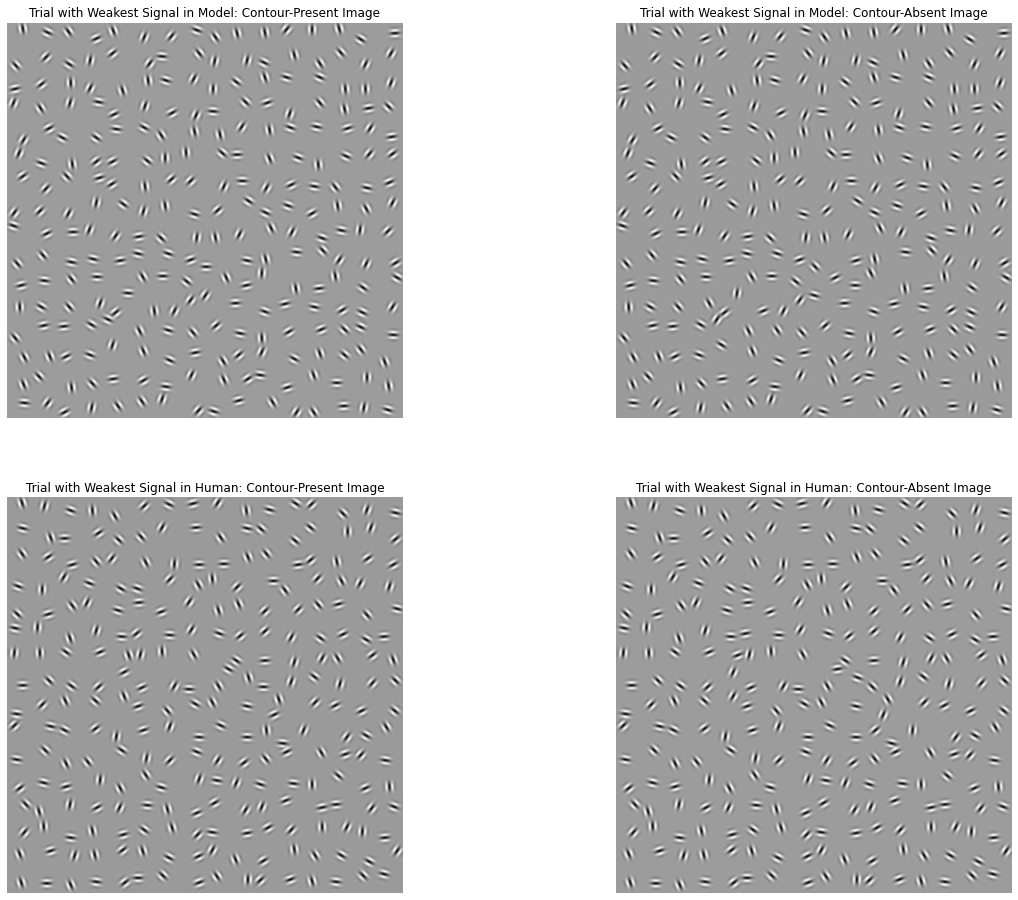

In [32]:
image_recorder_dict=torch.load(all_recorder_path[np.argmin(model_img_signal)])
_, _, model_img_contour_background, model_img_control_background=image_renderer(image_recorder_dict)


image_recorder_dict=torch.load(all_recorder_path[np.argmin(human_img_signal)])
_, _, human_img_contour_background, human_img_control_background=image_renderer(image_recorder_dict)


plt.figure(figsize=(20,16))


plt.subplot(2,2,1)
plt.imshow(np.array(model_img_contour_background),cmap='gray')
plt.axis('off')
plt.title('Trial with Weakest Signal in Model: Contour-Present Image')



plt.subplot(2,2,2)
plt.imshow(np.array(model_img_control_background),cmap='gray')
plt.axis('off')
plt.title('Trial with Weakest Signal in Model: Contour-Absent Image')




plt.subplot(2,2,3)
plt.imshow(np.array(human_img_contour_background),cmap='gray')
plt.axis('off')
plt.title('Trial with Weakest Signal in Human: Contour-Present Image')





plt.subplot(2,2,4)
plt.imshow(np.array(human_img_control_background),cmap='gray')
plt.axis('off')
plt.title('Trial with Weakest Signal in Human: Contour-Absent Image')








plt.show()

# Model and Human Performance as a function of curvature

In [33]:
psychophysics_dataset_norm = Psychophysics_Dataset(root=root_directory,transform=data_transform,get_B=get_B,get_D=get_D,get_A=get_A,get_contour='all')
psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)




all_betas=[]
all_labels=[]
all_outputs=[]
all_preds=[]
all_recorder_path=[]


for (inputs, b, d, a, nel, labels, record) in tqdm(psychophysics_loader_norm):
    inputs=inputs.to(device)
    output=loaded_spliced_model.forward(inputs).detach().cpu()
    _, preds = torch.max(output, 1)
        
    all_preds.append(preds)
    
    all_outputs.append(output)
    all_betas.append(b)
    all_labels.append(labels)
    all_recorder_path.append(np.array(record))

all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_preds=torch.cat(all_preds).numpy()
all_outputs=torch.cat(all_outputs).numpy()
all_recorder_path=np.concatenate(all_recorder_path)

unique_beta_vals=np.unique(all_betas)
model_unique_beta_acc=[]


for i in unique_beta_vals:
    
    acc=np.mean(all_labels[np.where(all_betas==i)[0]] == all_preds[np.where(all_betas==i)[0]])
    model_unique_beta_acc.append(acc)


  0%|          | 0/134 [00:00<?, ?it/s]

In [34]:
print(model_unique_beta_acc)
print(human_unique_beta_acc[:,0])

[0.9175, 0.9075, 0.935, 0.905, 0.86]
[0.93653846 0.85673077 0.65064103 0.49775641 0.45929487]


### Human + Explored model performance as a function of curvature

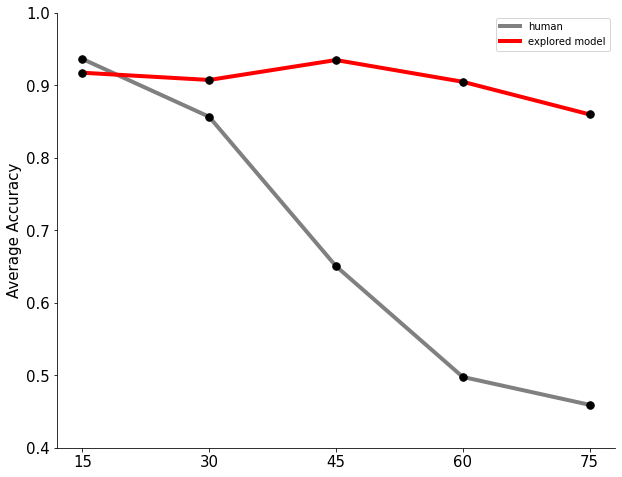

In [36]:
plt.figure(figsize=(10,8))



plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_unique_beta_acc,linewidth=4,label='explored model',color='r')
plt.plot(unique_beta_vals,model_unique_beta_acc,'.',color='k',markersize=15)








plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()
plt.show()